Introductory notebook for getting started with ExaMon and the Monte Cimone RISC-V cluster.

## Prerequisites

- Ability to connect with an account (ssh) to MonteCimone
- Web browser

## To access the Grafana instance via the browser

- On your laptop/workstation, create a tunnel with your MC user using the following command:
  ```bash
  ssh -L 3000:localhost:3000 -L 5000:localhost:5000 -p 2223 <your_mc_username>@137.204.56.52
  ```
- Open your web browser and go to the following page:
    - [http://localhost:3000/](http://localhost:3000/)
- Enter the following credentials to access the dashboard:
  ```bash
  User: ext_student
  Password: ext_student
  ```
- Once logged in, you will be in the HOME page. From there, you can open the example dashboard by visiting the following link:
    - http://localhost:3000/d/PaU3WSt7z/montecimone-overview?orgId=1

## To access the same data via script/notebook

- Prerequisites:
  - In addition to the previous prerequisites, the ability to run a jupyter server (py3) on your laptop/workstation

- On your laptop, start:
  - a tunnel as in the previous step
  - a python 3 jupyter server.
- To access the db, the examon-client is required
  - it is installed directly in the notebook by executing, once only, in a cell:
    ```bash
    - ! pip install https://github.com/fbeneventi/releases/releases/latest/download/examon-client.zip
    ```


In [1]:
%matplotlib inline

# ssh -L 3000:192.168.1.201:3000 -L 5000:192.168.1.201:5000 -p 2223 <mc_username>@137.204.56.52


import os
import numpy as np

import pandas as pd
from examon.examon import Client, ExamonQL

# Connect
USER = 'ext_student'
PWD = 'ext_student'
ex = Client('127.0.0.1', port='3000', user=USER, password=PWD, verbose=False, proxy=True)
sq = ExamonQL(ex)

In [3]:
pd.DataFrame(sq.metric_list)

,name
0,CYCLES
1,INSTRUCTIONS
2,dsk_total.read
3,dsk_total.writ
4,io_total.read
5,io_total.writ
6,load_avg.15m
7,load_avg.1m
8,load_avg.5m
9,memory_usage.buff


In [5]:
df = sq.DESCRIBE(metric='INSTRUCTIONS') \
    .execute()
    
df

,name,tag key,tag values
0,INSTRUCTIONS,node,"[mcimone-node-1, mcimone-node-2, mcimone-node-..."
1,INSTRUCTIONS,core,"[0, 1, 2, 3]"
2,INSTRUCTIONS,plugin,[pmu_pub]
3,INSTRUCTIONS,chnl,[data]
4,INSTRUCTIONS,cluster,[hifive]
5,INSTRUCTIONS,org,[unibo]


In [22]:
data = sq.SELECT('node','cluster','core') \
    .FROM('INSTRUCTIONS') \
    .TSTART(30, 'minutes') \
    .execute()
    
data.df_table.head(10)

,cluster,core,name,node,timestamp,value
0,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:52+02:00,1.794506e+11
1,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:52.500000+02:00,1.794748e+11
2,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:53+02:00,1.794753e+11
3,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:53.500000+02:00,1.794758e+11
4,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:54+02:00,1.794764e+11
5,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:54.500000+02:00,1.794769e+11
6,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:55+02:00,1.794775e+11
7,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:55.500000+02:00,1.794780e+11
8,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:56+02:00,1.794786e+11
9,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-27 19:20:56.500000+02:00,1.794791e+11


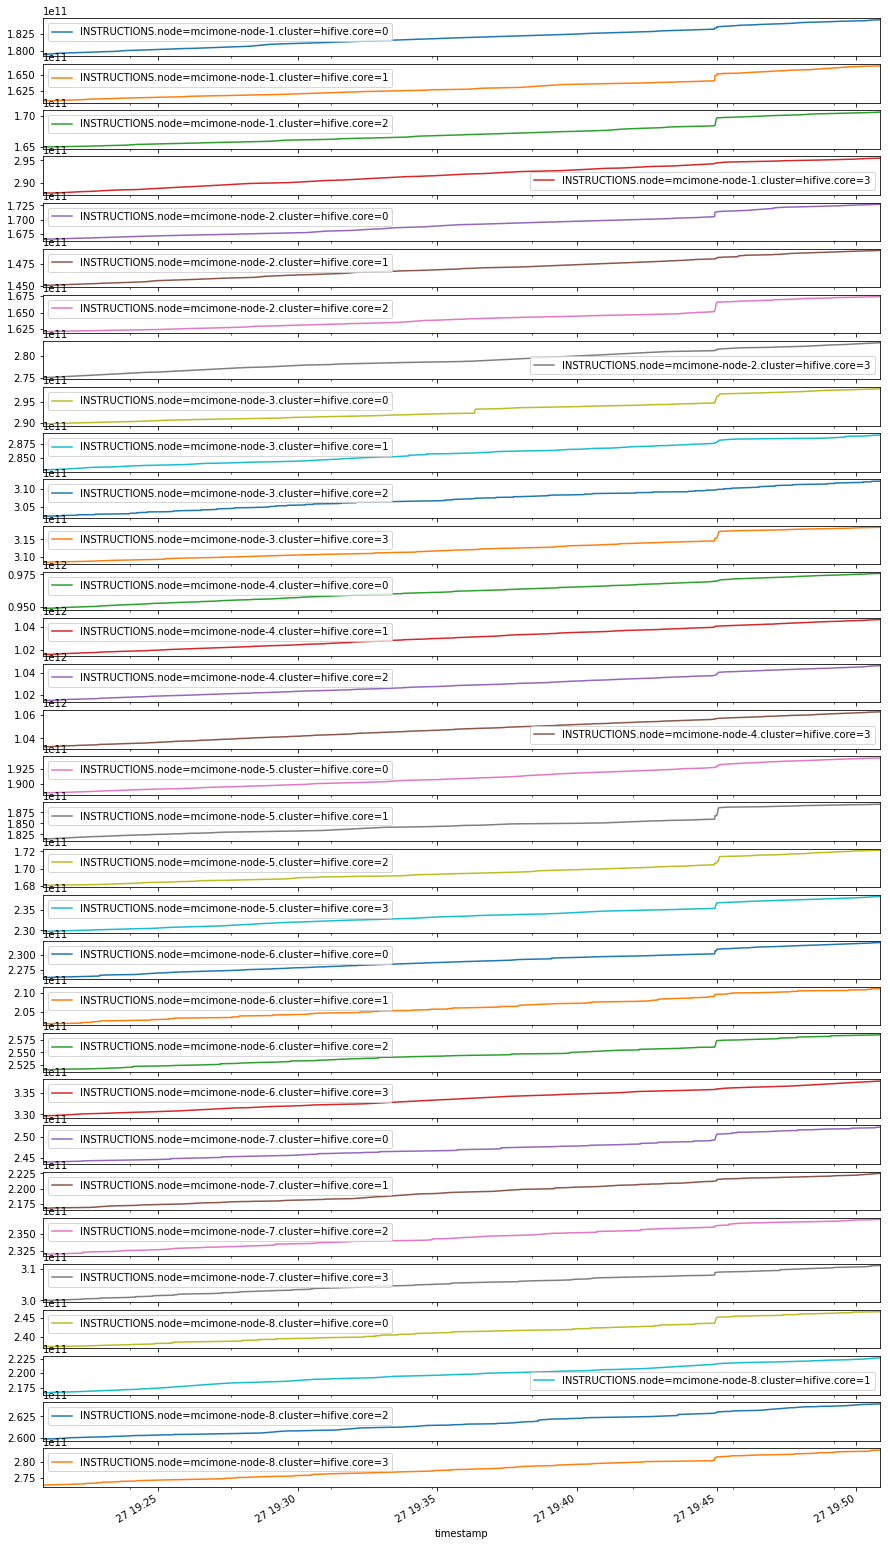

In [24]:
data.to_series(flat_index=True, interp='time', dropna=True).df_ts.plot(figsize=[15,30], subplots=True);

In [36]:
import json

# Setup 
sq.jc.JOB_TABLES.extend(['job_info_hifive'])

data = sq.SELECT('name','user_id','job_id','job_state','start_time','end_time','nodes','num_nodes','num_cpus','work_dir') \
    .FROM('job_info_hifive') \
    .WHERE(node='mcimone-node-1') \
    .TSTART('27-06-2023 08:09:00') \
    .TSTOP('28-06-2023 23:09:00') \
    .execute()  

df = pd.DataFrame(json.loads(data))
df.head(50)

,end_time,job_id,job_state,name,nodes,num_cpus,num_nodes,start_time,user_id,work_dir
0,2023-06-27T18:18:13.000Z,2825,CANCELLED,bash,mcimone-node-1,1,1,2023-06-27T18:00:08.000Z,2001,/home/abartolini/HPL/src/hpl-2.3
1,2023-06-28T11:11:47.000Z,2868,COMPLETED,test,mcimone-node-1,4,1,2023-06-28T11:11:47.000Z,6010,/home/userdeiphd10
2,2023-06-27T14:48:34.000Z,2821,FAILED,hpl,mcimone-node-1,2,1,2023-06-27T14:48:32.000Z,2001,/home/abartolini
3,2023-06-28T11:15:55.000Z,2872,COMPLETED,test,mcimone-node-1,4,1,2023-06-28T11:15:53.000Z,6008,/home/userdeiphd08
4,2023-06-28T07:05:00.000Z,2860,COMPLETED,bash,mcimone-node-1,1,1,2023-06-28T07:04:54.000Z,6001,/home/userdeiphd01
5,2023-06-27T18:19:49.000Z,2831,FAILED,hpl,mcimone-node-1,2,1,2023-06-27T18:19:46.000Z,2001,/home/abartolini
6,2023-06-28T11:32:38.000Z,2887,COMPLETED,sleep,mcimone-node-1,1,1,2023-06-28T11:32:08.000Z,6005,/home/userdeiphd05
7,2023-06-28T11:27:32.000Z,2877,COMPLETED,bash,mcimone-node-1,1,1,2023-06-28T11:27:26.000Z,6008,/home/userdeiphd08/02_ex
8,2023-06-28T11:19:44.000Z,2874,COMPLETED,test,mcimone-node-1,4,1,2023-06-28T11:19:33.000Z,6010,/home/userdeiphd10
9,2023-06-27T21:11:24.000Z,2845,COMPLETED,stream,mcimone-node-1,4,1,2023-06-27T21:11:05.000Z,2001,/home/abartolini


In [41]:
import json


data = sq.SELECT('name','user_id','job_id','job_state','start_time','end_time','nodes','num_nodes','num_cpus','work_dir') \
    .FROM('job_info_hifive') \
    .WHERE(job_id='2866') \
    .TSTART('27-06-2023 08:09:00') \
    .execute()  

df = pd.DataFrame(json.loads(data))
df.head()

,end_time,job_id,job_state,name,nodes,num_cpus,num_nodes,start_time,user_id,work_dir
0,2023-06-28T08:44:09.000Z,2866,CANCELLED,hpl,mcimone-node-1,4,1,2023-06-28T07:38:27.000Z,2001,/home/abartolini


In [69]:
data = sq.SELECT('node','cluster','core') \
    .FROM('INSTRUCTIONS') \
    .WHERE(node='mcimone-node-1') \
    .TSTART('28-06-2023 07:38:27') \
    .TSTOP('28-06-2023 08:44:09') \
    .execute()
    
data.df_table.head(10)

,cluster,core,name,node,timestamp,value
0,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:27+02:00,3.100586e+11
1,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:27.500000+02:00,3.100629e+11
2,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:28+02:00,3.100923e+11
3,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:28.500000+02:00,3.100927e+11
4,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:29+02:00,3.100957e+11
5,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:29.500000+02:00,3.101099e+11
6,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:30+02:00,3.101479e+11
7,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:30.500000+02:00,3.103973e+11
8,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:31+02:00,3.108438e+11
9,hifive,0,INSTRUCTIONS,mcimone-node-1,2023-06-28 07:38:31.500000+02:00,3.113999e+11


In [46]:
data.df_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252320 entries, 0 to 252319
Data columns (total 6 columns):
cluster      252320 non-null object
core         252320 non-null object
name         252320 non-null object
node         252320 non-null object
timestamp    252320 non-null datetime64[ns, Europe/Rome]
value        252320 non-null float64
dtypes: datetime64[ns, Europe/Rome](1), float64(1), object(4)
memory usage: 11.6+ MB


In [70]:
df = data.df_table

# Sort the DataFrame by 'timestamp'
df = df.sort_values('timestamp')

# Calculate the time difference between consecutive rows for each core and node
df['time_diff'] = df.groupby(['core', 'node'])['timestamp'].diff()

# Calculate the Instructions per second for each core and node
df['instructions_per_second'] = df.groupby(['core', 'node'])['value'].diff() / df['time_diff'].dt.total_seconds()

# Drop rows with NaN values (first row for each core and node)
df = df.dropna()

# Print the resulting DataFrame
print(df[['cluster', 'core', 'node', 'instructions_per_second']])

      cluster core            node  instructions_per_second
23656  hifive    3  mcimone-node-1               38523114.0
1      hifive    0  mcimone-node-1                8620240.0
7886   hifive    1  mcimone-node-1               14623376.0
15771  hifive    2  mcimone-node-1               14995134.0
7887   hifive    1  mcimone-node-1               83411746.0
23657  hifive    3  mcimone-node-1               11415616.0
2      hifive    0  mcimone-node-1               58787754.0
15772  hifive    2  mcimone-node-1               14676376.0
23658  hifive    3  mcimone-node-1                1645138.0
7888   hifive    1  mcimone-node-1                 350340.0
3      hifive    0  mcimone-node-1                 803444.0
15773  hifive    2  mcimone-node-1                1136978.0
23659  hifive    3  mcimone-node-1                2783320.0
7889   hifive    1  mcimone-node-1                5273074.0
15774  hifive    2  mcimone-node-1                2275020.0
4      hifive    0  mcimone-node-1      

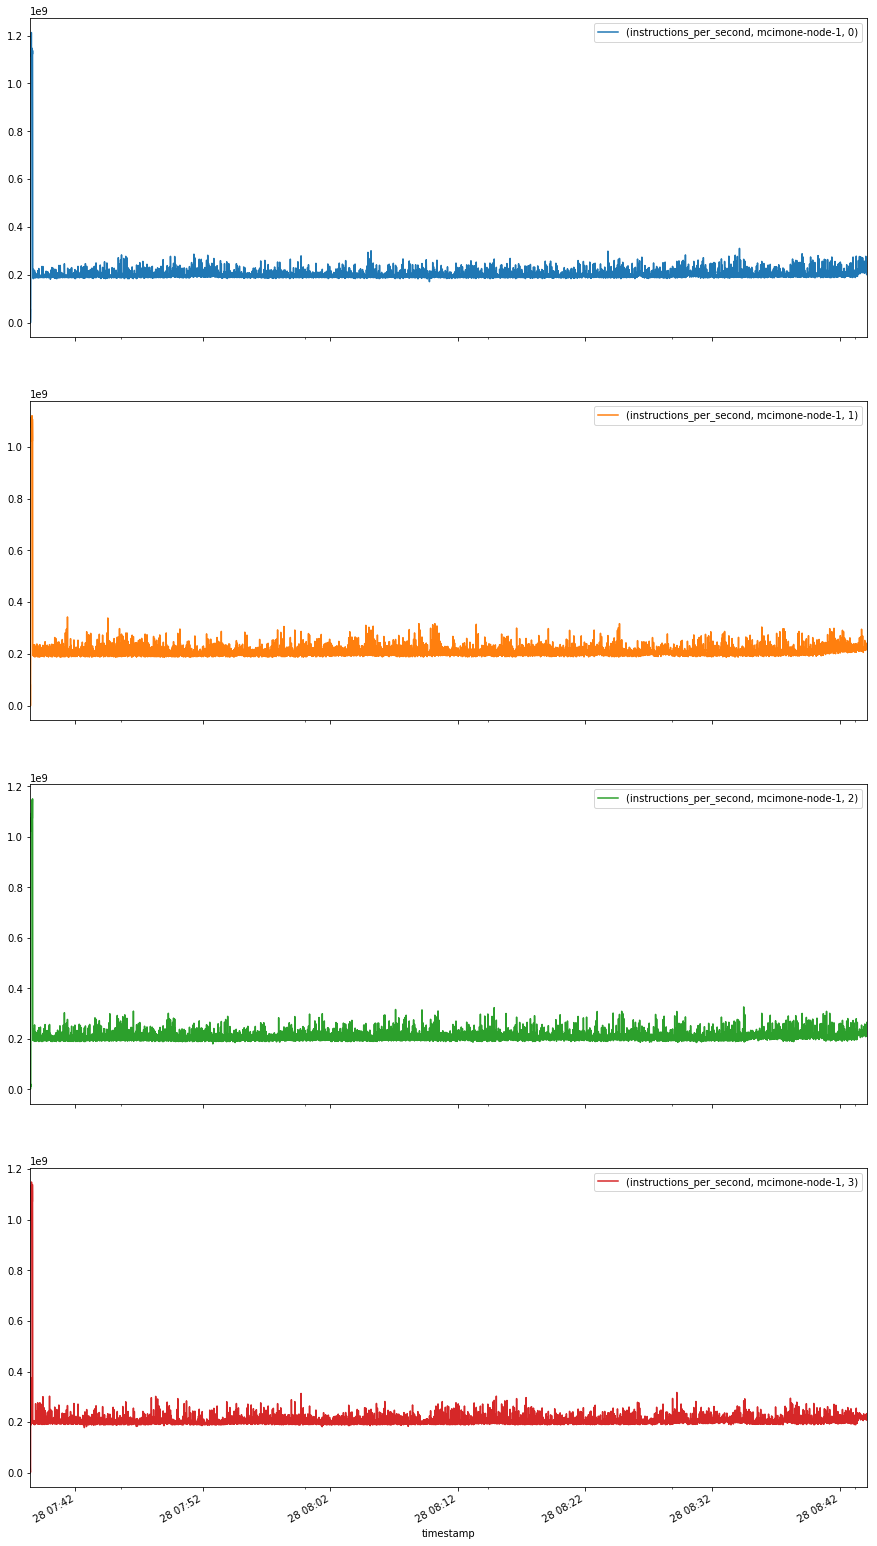

In [71]:
df[['timestamp','node','core','instructions_per_second']]\
.pivot_table(index='timestamp', columns=['node','core'], dropna=True, aggfunc='first')\
.plot(figsize=[15,30], subplots=True);